In [ ]:
!pip install tensorflow-datasets

In [ ]:
# import tensorflow_datasets as tfds
# import tensorflow as tf
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x/255.0 for x in [63.0, 62.1, 66.7]])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

fashion_trainset = datasets.FashionMNIST(root='./fmnist/', train=True, download=True, transform=transform)


100%|██████████| 26421880/26421880 [00:05<00:00, 4588529.45it/s] 


Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272465.90it/s]


Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5011488.74it/s]


Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12423634.63it/s]


Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


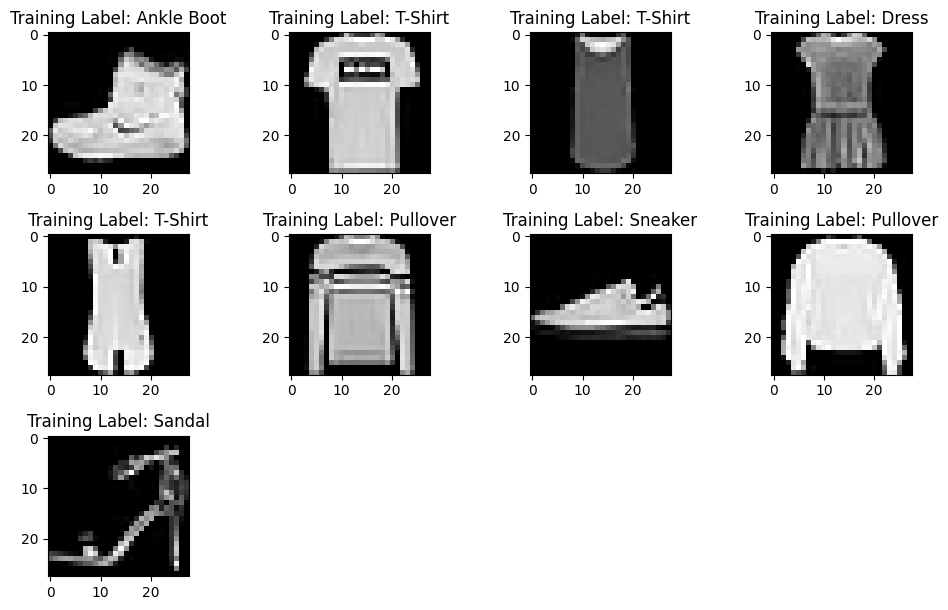

In [ ]:

labels_map = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle Boot')
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
for i in range(1, 10):
  fig.add_subplot(rows, columns, i)
  fig.tight_layout()
  plt.imshow(fashion_trainset.train_data[i-1].numpy(), cmap='gray')
  plt.title(f'Training Label: {labels_map[fashion_trainset.train_labels[i-1]]}')
plt.show()

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self,x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
MLP_network = MLP()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP_network.parameters(), lr=0.001, betas=(0.9,0.99), eps=1e-08,weight_decay=0.001 )

In [ ]:
num_train = len(fashion_trainset)
indices = list(range(num_train))

split = 54000
train_index = np.random.choice(indices, size= split, replace=False)
validation_index = list(set(indices)- set(train_index))

train_sampler = SubsetRandomSampler(train_index)
validation_sampler = SubsetRandomSampler(validation_index)

train_loader1 = torch.utils.data.DataLoader(fashion_trainset,batch_size=16, sampler=train_sampler)
validation_loader1 = torch.utils.data.DataLoader(fashion_trainset,batch_size=16, sampler=validation_sampler)


In [ ]:
num_epochs = 20
total_step = len(train_loader1)
loss_f1 = []
print('-'*20)

for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader1, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = MLP_network(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch: {epoch+1} | loss:{running_loss/total_step}")

  loss_f1.append(running_loss / total_step)
print("Finished")

--------------------
Epoch: 1 | loss:0.3462449027978712
Epoch: 2 | loss:0.3399600072643823
Epoch: 3 | loss:0.3349199797850516
Epoch: 4 | loss:0.33103838057153756
Epoch: 5 | loss:0.3280910213613124
Epoch: 6 | loss:0.3261706828535707
Epoch: 7 | loss:0.3242551268606826
Epoch: 8 | loss:0.3245848517892537
Epoch: 9 | loss:0.32319302972868363
Epoch: 10 | loss:0.3214570290464218
Epoch: 11 | loss:0.3183574362408232
Epoch: 12 | loss:0.31796054334469415
Epoch: 13 | loss:0.317705869147761
Epoch: 14 | loss:0.3151104716172925
Epoch: 15 | loss:0.3148083596902865
Epoch: 16 | loss:0.31587824658621794
Epoch: 17 | loss:0.31563690613072226
Epoch: 18 | loss:0.3127983676407624
Epoch: 19 | loss:0.31383475950056755
Epoch: 20 | loss:0.31263882776929275
Finished


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in validation_loader1:
    images, labels = data
    outputs = MLP_network(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total}")

Accuracy: 84.56666666666666


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in validation_loader1:
    images, labels = data
    outputs = MLP_network(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print(f"Accuracy of Class {labels_map[i]} : {100 * class_correct[i] / class_total[i]}")


Accuracy of Class T-Shirt : 80.97826086956522
Accuracy of Class Trouser : 98.04469273743017
Accuracy of Class Pullover : 63.20224719101124
Accuracy of Class Dress : 89.50276243093923
Accuracy of Class Coat : 84.21052631578948
Accuracy of Class Sandal : 98.26732673267327
Accuracy of Class Shirt : 69.6
Accuracy of Class Sneaker : 64.19098143236074
Accuracy of Class Bag : 96.1038961038961
Accuracy of Class Ankle Boot : 99.5049504950495


this code showes that accuracy some of class is better than others. for example this Model learn to detect Trouser,Bag and Boot better very well. (more than 95%)

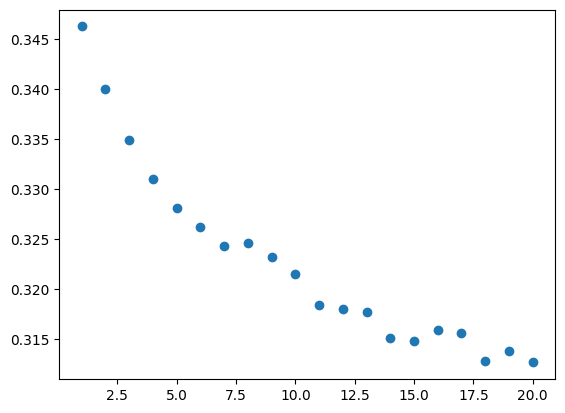

In [ ]:
plt.scatter([x+1 for x in range(20)], loss_f1)

Probably by deepening the network causes better accuracy